In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm
from p_tqdm import p_map
import librosa
import librosa.display
from random import shuffle
from skimage.transform import resize
import warnings


In [15]:
warnings.filterwarnings('ignore')

### LISTAGE DES FICHIERS CONTENUS DANS *DATA*

In [16]:
from random import shuffle, seed

HOUSE_FOLDER = "/home/george/code/clumzy/electronic_tagger/datasets/audio_files/acid_techno"
TECHNO_FOLDER = "/home/george/code/clumzy/electronic_tagger/datasets/audio_files/hard_techno"

exts = ['*.mp3', '*.aiff', '*.flac','*.wav']
house_files = [f for ext in exts for f in glob(os.path.join(HOUSE_FOLDER, ext))]
techno_files = [f for ext in exts for f in glob(os.path.join(TECHNO_FOLDER, ext))]
seed(42)
shuffle(house_files)
seed(42)
shuffle(techno_files)

In [17]:
len(house_files), len(techno_files)

(154, 244)

### FEATURE MAKER FUNCTION & SCALER FUNCTION

Ces fonctions nous servent à scaler et créer **l'image feature** pour un fichier donné.

In [18]:
import pydub

def rgb_transform(data):
    return (((data+abs(data.min()))/(data+abs(data.min())).max())*255).astype(np.uint8)

def get_from_pydub(file, normalized=True, num_sample=5, sample_length=6, sample_rate=44100):
    NUM_SAMPLE = num_sample
    SAMPLING_RATE = sample_rate
    song = pydub.AudioSegment.from_file(file).set_channels(1)
    #ON REMET LE SAMPLE RATE A 44100 SI CE N'EST PAS LE CAS
    if song.frame_rate != SAMPLING_RATE: song = song.set_frame_rate(sample_rate)
    SAMPLE_LENGTH = sample_length*1000
    # LA CHANSON EST DECOUPEE EN NUM_SAMPLES MORCEAUX, DE LONGEUR SAMPLE_LENGTH(SECONDES)
    song_inter = np.linspace(0,(len(song)-(SAMPLE_LENGTH+10000)),NUM_SAMPLE).astype(int)
    y = np.hstack([song[song_inter[i]:song_inter[i]+SAMPLE_LENGTH].get_array_of_samples() for i in range(0,NUM_SAMPLE)])
    # ON RENVOIE UNE VERSION NORMALISEE DE L'AMPLITUDE
    if normalized:
        return song.frame_rate, np.float32(y) / 2**15
    else:
        return song.frame_rate, y

def song_to_img(file, hop_length=1024, num_sample=5, sample_length=6, sample_rate=44100):
    # VALEUR TEMPORAIRE DE HAUTEUR D'IMAGE, A REVOIR PLUS TARD /!\
    warnings.filterwarnings('ignore')
    HOP_LENGTH = hop_length
    NUM_SAMPLE = num_sample
    SAMPLE_LENGTH = sample_length
    SAMPLING_RATE = sample_rate
    pydub_sr, song_extracts = get_from_pydub(
        file, 
        normalized=True,
        num_sample=NUM_SAMPLE,
        sample_length=SAMPLE_LENGTH,
        sample_rate=SAMPLING_RATE)
    # ON AFFICHE UN AVERTISSEMENT SI LE SAMPLING RATE N'EST PAS BON

    #CALCUL DU CONSTANT Q
    constant_q_temp = librosa.cqt(song_extracts, hop_length=HOP_LENGTH, sr=SAMPLING_RATE)
    constant_q = librosa.amplitude_to_db(np.abs(constant_q_temp))
    
    #CALCUL DU MFCC, LES FREQUENCES QUE L'ON ENTEND
    ## CE FEATURE NE MARCHE PAS TRES BIEN /!\
    mfcc_song = librosa.feature.mfcc(y=song_extracts, n_mfcc=26, sr=SAMPLING_RATE, lifter=512, hop_length=HOP_LENGTH)

    #CALCUL DU CHROMAGRAMME (LES NOTES)
    ## VERSION CENS
    chromacens = librosa.feature.chroma_cens(y=song_extracts, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_chroma=36, win_len_smooth=12, C=constant_q_temp)
    ## VERSION "CLASSIQUE" VARIANTE CQT
    #chromacqt = librosa.feature.chroma_cqt(y=song_extracts, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_chroma=12, C=constant_q_temp)
    
    ## VERSION "CLASSIQUE" VARIANTE STFT, A REESSAYER PLUS TARD
    #chromastft12 = librosa.feature.chroma_stft(y=song_extracts, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_chroma=12, C=constant_q_temp)
    
    ## VERSION "CLASSIQUE" VARIANTE STFT, A REESSAYER PLUS TARD, 36 bins
    #chromastft36 = librosa.feature.chroma_stft(y=song_extracts, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_chroma=36)

    #CREATION DE LA SHAPE FINALE A PARTIR DES PLUS GRANDES VALEURS DE NOS TROIS FEATURES
    IM_HEIGHT = max(constant_q.shape[0], mfcc_song.shape[0], chromacens.shape[0])
    IM_WIDTH = max(constant_q.shape[1], mfcc_song.shape[1], chromacens.shape[1])
    IM_SHAPE = (IM_HEIGHT, IM_WIDTH)

    r = rgb_transform(resize(constant_q, (IM_SHAPE), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)

    g = rgb_transform(resize(mfcc_song, (IM_SHAPE), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)

    b = rgb_transform(resize(chromacens, (IM_SHAPE), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)
    
    rgb = np.dstack((r,g,b)).astype(np.uint8)
    return rgb

### EXEMPLE D'UNE CREATION DE FEATURES

In [19]:
SONG_NUM = 2
print(house_files[SONG_NUM])
img = song_to_img(
    house_files[SONG_NUM], 
    hop_length=2048,
    num_sample = 5,
    sample_length=6,
    sample_rate = 44100)
print(img.shape)
r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]

/home/george/code/clumzy/electronic_tagger/datasets/audio_files/acid_techno/NAKANO BLU - Data Folder.mp3
(84, 646, 3)


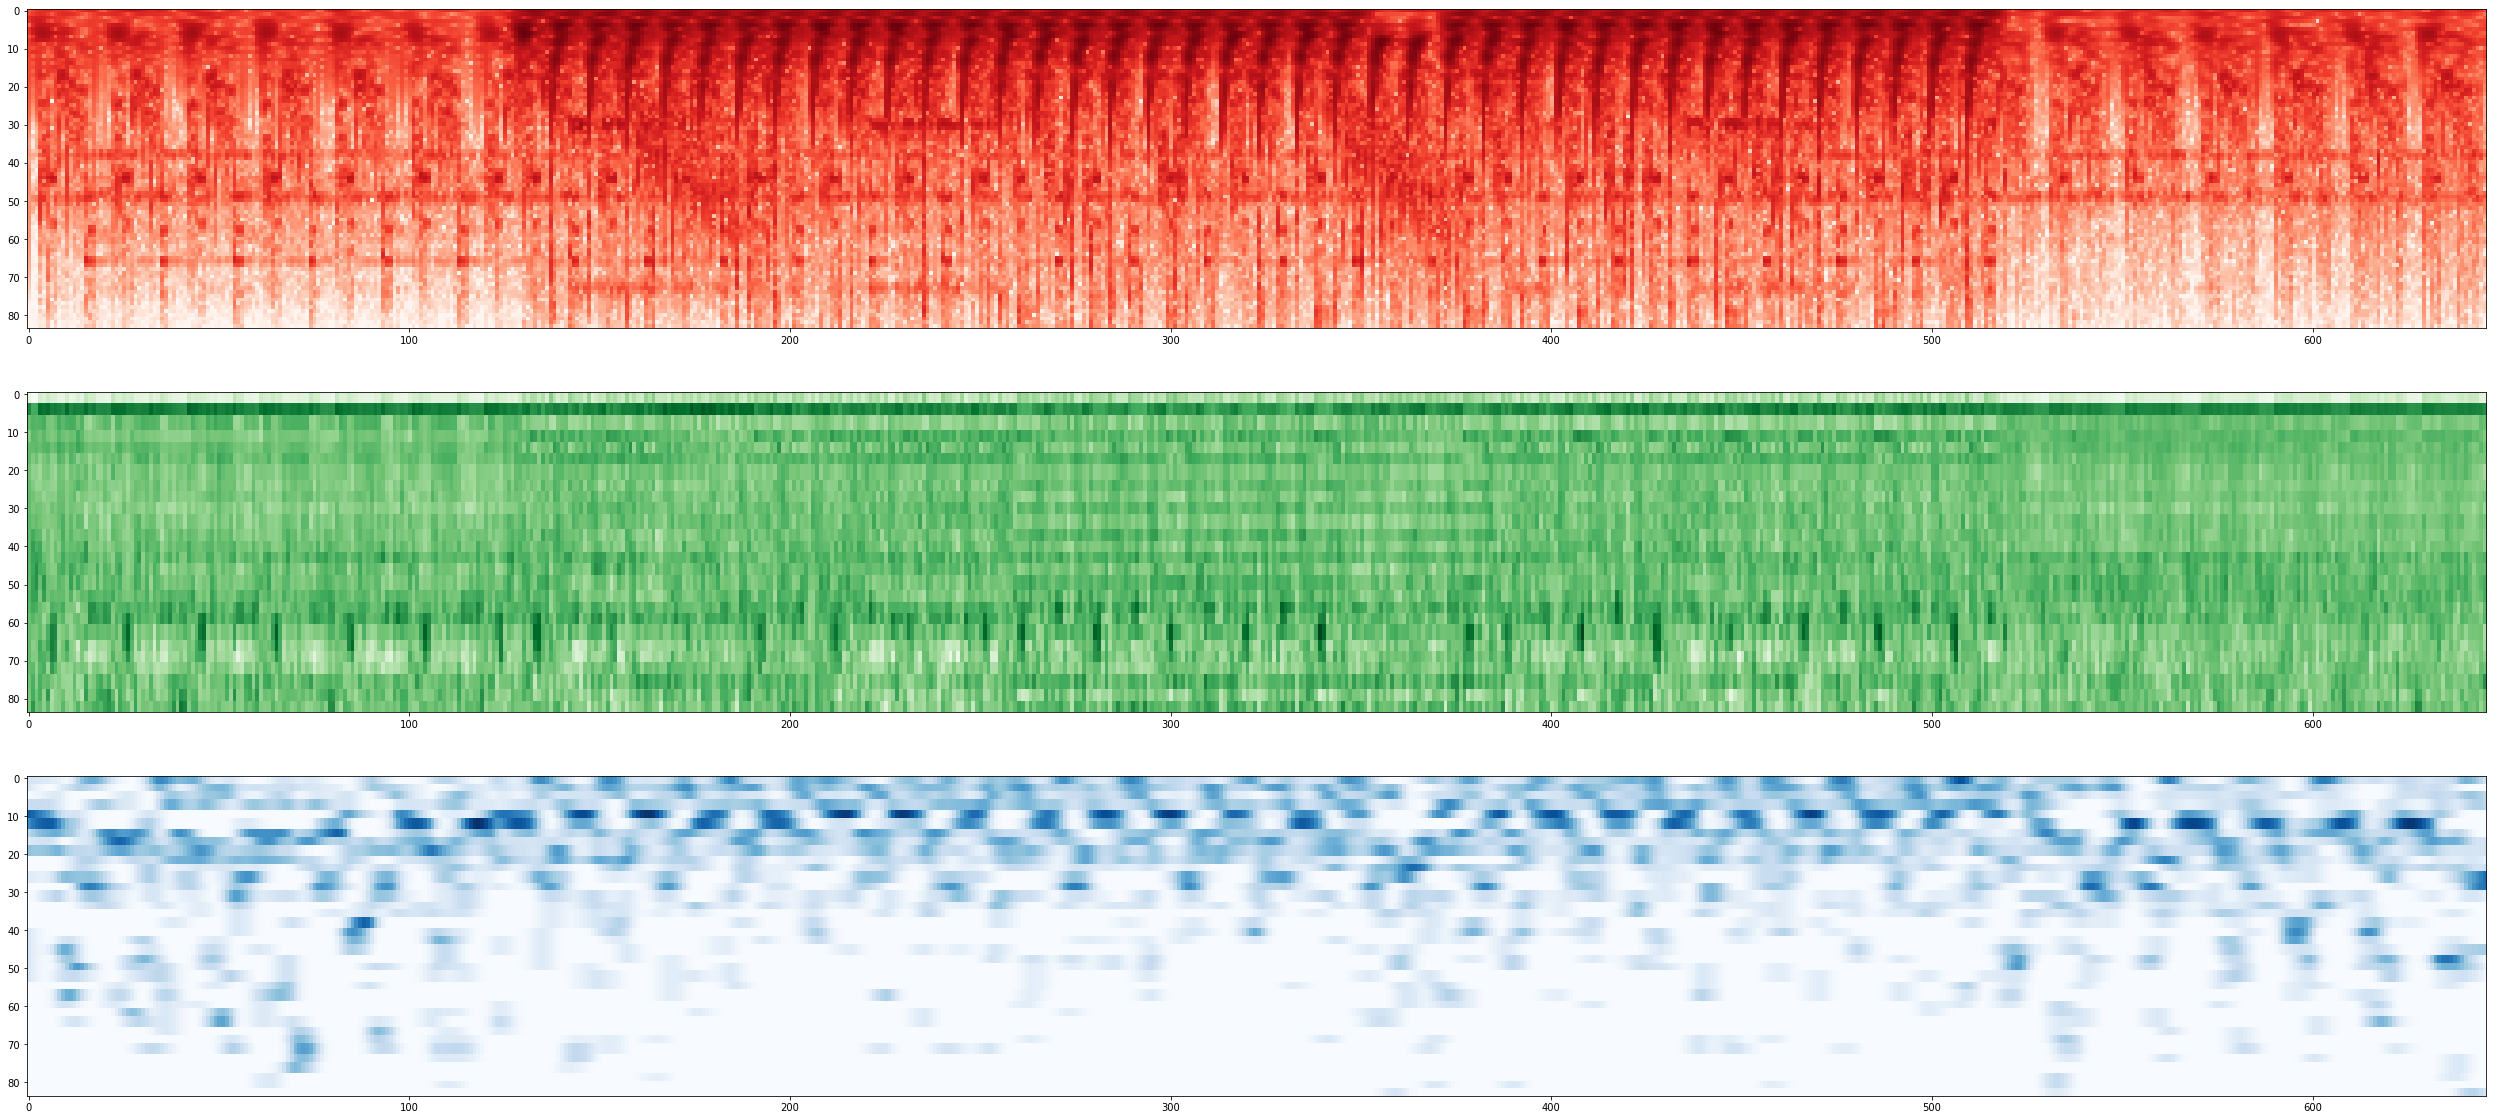

In [20]:
plt.figure(figsize=(60,20))
plt.subplot(3,1,1)
plt.imshow((r), cmap="Reds")
plt.subplot(3,1,2)
plt.imshow(g, cmap="Greens")
plt.subplot(3,1,3)
plt.imshow(b, cmap="Blues")
plt.show()

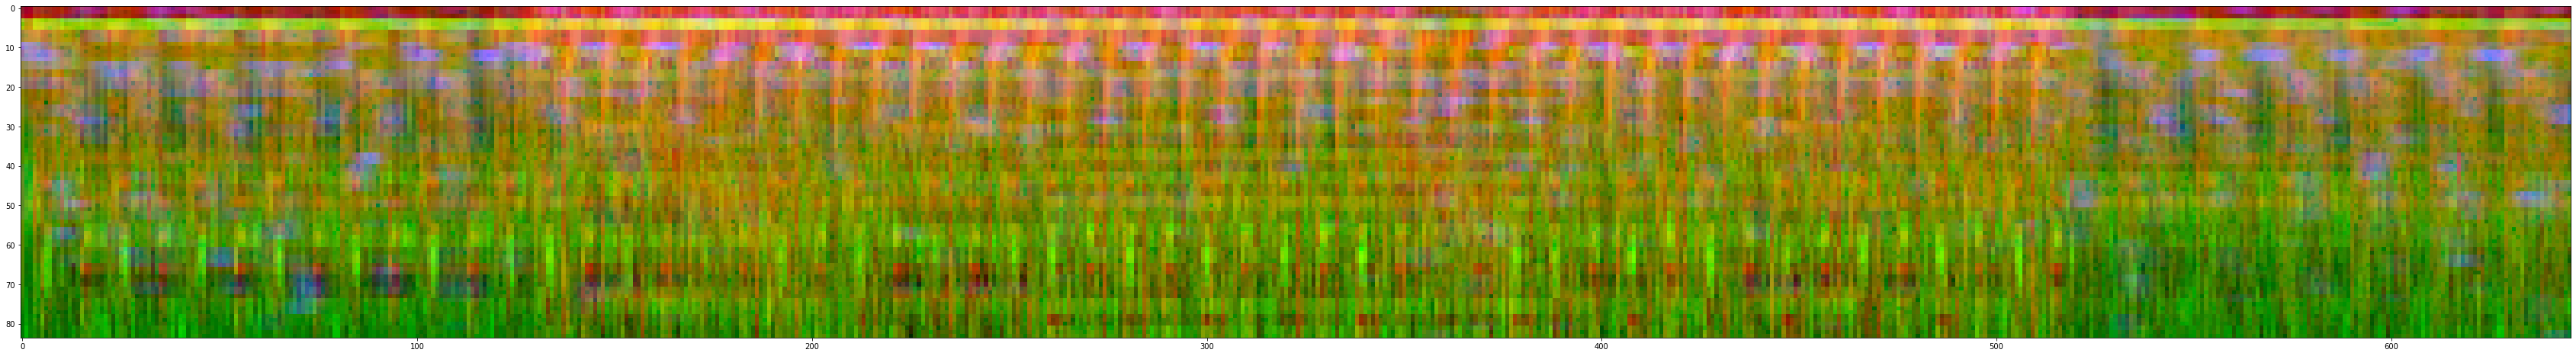

In [21]:
rgb = np.dstack((r,g,b))
plt.figure(figsize=(60,8))
plt.imshow(rgb)

### CREATION DES FEATURES POUR LA LISTE DES MUSIQUES

In [22]:
START_SONG = 0
HOW_MANY = 150


ar1 = np.array(p_map(
    song_to_img,
    house_files[START_SONG:START_SONG+HOW_MANY], 
    [1024]*HOW_MANY, 
    [5]*HOW_MANY, 
    [6]*HOW_MANY,
    [44100]*HOW_MANY), dtype=np.uint8)
print(ar1.shape)
ar2 = np.array(p_map(
    song_to_img,
    techno_files[START_SONG:START_SONG+HOW_MANY], 
    [1024]*HOW_MANY, 
    [5]*HOW_MANY, 
    [6]*HOW_MANY,
    [44100]*HOW_MANY), dtype=np.uint8)
print(ar2.shape)

100%|██████████| 150/150 [01:44<00:00,  1.43it/s]

(150, 84, 1292, 3)



100%|██████████| 150/150 [01:47<00:00,  1.39it/s]

(150, 84, 1292, 3)


In [23]:
X_1 = np.vstack([ar1, ar2])

X_2 = [os.path.basename(house_file) for house_file in tqdm(house_files[START_SONG:START_SONG+HOW_MANY])] + [os.path.basename(techno_file) for techno_file in tqdm(techno_files[START_SONG:START_SONG+HOW_MANY])]

X = (X_1,X_2)

100%|██████████| 150/150 [00:00<00:00, 242258.61it/s]


### EXPORT DES FEATURES

In [24]:
import pickle
pickle.dump( X, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","acid_vs_hard_bigger36.pkl"), "wb" ) )

### CREATION DE LA TARGET: 1 = HOUSE et 0 = TECHNO

In [25]:
y = np.hstack([np.ones(len(X[0])//2),np.zeros(len(X[0])//2)]).astype(int)

### AFFICHAGE DES FEATURES

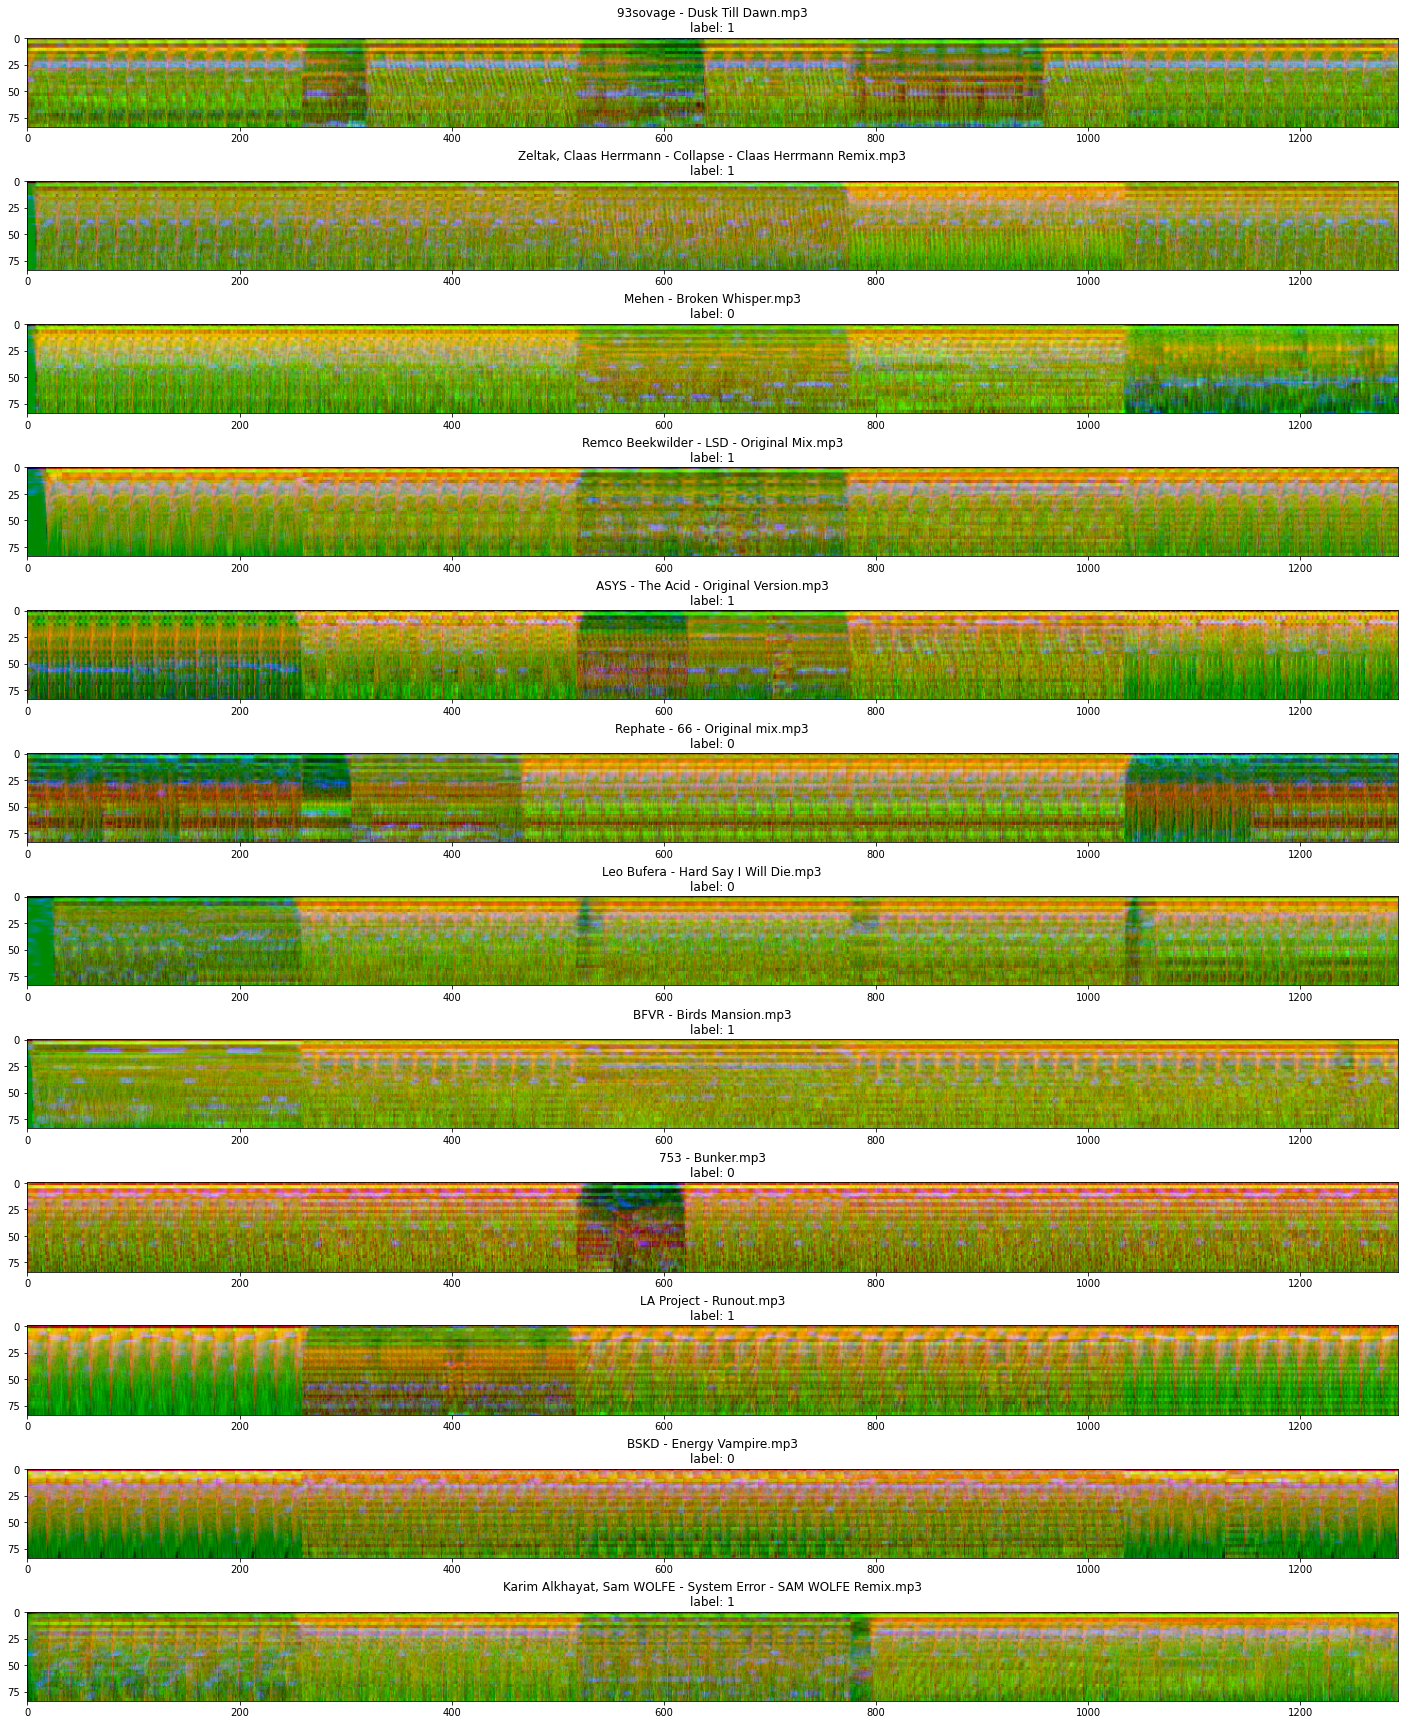

In [26]:
images = np.random.choice(range(X[0].shape[0]), 12, replace = False) #type: ignore
plt.figure(2, figsize=(24, 24))
for i in range(1, 13):
    plt.subplot(12, 1, i)
    plt.imshow(X[0][images[i-1]])
    plt.title(f"{X[1][images[i-1]]}\nlabel: {y[images[i-1]]}")
plt.tight_layout()
plt.show()